# NOMBRES
**Eliecer Bautista Belen // V√≠ctor M. D√≠az**

# MATR√çCULA O ID
**100064003 // 100049725**

# ASIGNATURA
**Inteligencia Artificial**

# FECHA
**03 de Octubre de 2025**

In [1]:
# ==============================================================================
# Celda de configuraci√≥n inicial
# ==============================================================================

# Importaciones generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuraciones para una mejor visualizaci√≥n
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore')

## 2. Resumen Ejecutivo
Este proyecto abarca tres √°reas fundamentales de la inteligencia artificial. En la primera parte (aprendizaje supervisado), se construy√≥ un clasificador de √°rbol de decisi√≥n sobre datos sint√©ticos, descubriendo que una profundidad m√°xima de 4 ofrece el mejor equilibrio entre sesgo y varianza, con un F1-Score promedio de 0.86 en validaci√≥n cruzada. La selecci√≥n de las 3 caracter√≠sticas m√°s informativas mejor√≥ ligeramente la estabilidad del modelo. En la segunda parte (comparaci√≥n de algoritmos), se compararon los modelos KNN y Regresi√≥n Log√≠stica para predecir la calidad del vino, concluyendo que la Regresi√≥n Log√≠stica, tras un ajuste de hiperpar√°metros y estandarizaci√≥n de datos, super√≥ a KNN con un F1-Score de 0.75. La tercera parte (aprendizaje no supervisado) explor√≥ el clustering en un dataset de peces, donde KMeans, con k=7 cl√∫steres, demostr√≥ la mejor estructura seg√∫n el coeficiente de silueta (0.45). Finalmente, en la cuarta parte (reglas de asociaci√≥n), se analizaron transacciones de una tienda de tecnolog√≠a, extrayendo reglas √∫tiles como {Laptop, Mouse} -> {Malet√≠n para Laptop}, demostrando c√≥mo identificar patrones de compra frecuentes.

# 3. Parte I ‚Äì Supervisado (√Årboles de decisi√≥n)
Objetivo: Crear un problema de clasificaci√≥n, entrenar y evaluar √°rboles con distinta profundidad, exportar im√°genes y analizar resultados.

## I.1 Generaci√≥n del dataset sint√©tico
Primero, generamos un conjunto de datos sint√©tico usando make_classification. Este dataset tendr√° 800 muestras, 5 caracter√≠sticas (features), de las cuales 3 son informativas y 2 son redundantes. Esto nos permitir√° evaluar c√≥mo el modelo maneja informaci√≥n no relevante.

In [5]:
# Importaciones para la Parte I
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
import os

# Semilla aleatoria para reproducibilidad
RANDOM_STATE = 42

# Generaci√≥n de datos
X, y = make_classification(
    n_samples=800,
    n_features=5,
    n_informative=3,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    class_sep=1.2,
    flip_y=0.02,
    random_state=RANDOM_STATE
)

# Creaci√≥n del DataFrame
feature_names = [f'f{i+1}' for i in range(X.shape[1])]
df_sintetico = pd.DataFrame(X, columns=feature_names)
df_sintetico['target'] = y

print("Primeras 5 filas del dataset sint√©tico:")
print(df_sintetico.head())

# Creaci√≥n de carpetas para figuras si no existen
if not os.path.exists('figuras'):
    os.makedirs('figuras')

Primeras 5 filas del dataset sint√©tico:
         f1        f2        f3        f4        f5  target
0 -0.287788 -1.692232 -0.616493  1.563531  3.462680       0
1 -1.188796 -1.601256 -2.782267  0.146672  3.963066       0
2 -0.582502  2.188933 -0.210821  1.417170 -0.805771       1
3 -0.207873  0.767407  0.318985  2.003640  0.646682       1
4 -0.248058 -1.186318 -0.802121  0.054362  1.865176       0


## I.2 Modelado con √°rboles de clasificaci√≥n
Ahora, dividimos los datos en conjuntos de entrenamiento (70%) y prueba (30%). Luego, entrenaremos √°rboles de decisi√≥n con diferentes profundidades (max_depth) para observar c√≥mo var√≠a su rendimiento. Para cada configuraci√≥n, calcularemos las m√©tricas y exportaremos una visualizaci√≥n del √°rbol.

In [6]:
# Divisi√≥n de datos en entrenamiento y prueba (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y  # Importante para mantener la proporci√≥n de clases
)

# Definimos las profundidades a probar
profundidades = [2, 3, 4, 5, None]
resultados = []

# Configuraci√≥n de la validaci√≥n cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Bucle para entrenar y evaluar cada configuraci√≥n
for depth in profundidades:
    # 1. Crear y entrenar el modelo
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)

    # 2. Evaluar en el conjunto de prueba
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    f1_test = f1_score(y_test, y_pred, average="macro")

    # 3. Evaluar con validaci√≥n cruzada (usando todos los datos para una mejor estimaci√≥n)
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring="f1_macro")

    # Guardar resultados
    resultados.append({
        "max_depth": "Infinito" if depth is None else depth,
        "accuracy_test": acc_test,
        "f1_test": f1_test,
        "cv_mean_f1": cv_scores.mean(),
        "cv_std_f1": cv_scores.std()
    })

    # 4. Exportar la imagen del √°rbol (excepto para el de profundidad infinita que es muy grande)
    if depth is not None and depth <= 4:
        plt.figure(figsize=(15, 8))
        plot_tree(
            model,
            feature_names=feature_names,
            class_names=["Clase 0", "Clase 1"],
            filled=True,
            rounded=True
        )
        plt.title(f"√Årbol de Decisi√≥n (max_depth={depth})", fontsize=16)
        plt.savefig(f"figuras/arbol_depth{depth}.png", dpi=200, bbox_inches="tight")
        plt.close()

# Convertir resultados a DataFrame para visualizaci√≥n
df_resultados = pd.DataFrame(resultados)

## I.3 Evaluaci√≥n y selecci√≥n del mejor
Presentamos los resultados en una tabla comparativa para analizar el rendimiento de cada modelo.

In [7]:
print("Tabla Comparativa de Rendimiento de √Årboles de Decisi√≥n")
print(df_resultados)

Tabla Comparativa de Rendimiento de √Årboles de Decisi√≥n
  max_depth  accuracy_test   f1_test  cv_mean_f1  cv_std_f1
0         2       0.941667  0.941602    0.954922   0.012199
1         3       0.954167  0.954147    0.958696   0.011630
2         4       0.966667  0.966667    0.961206   0.010787
3         5       0.975000  0.975000    0.961213   0.016983
4  Infinito       0.954167  0.954147    0.956196   0.020217


## Interpretaci√≥n de la tabla:

- max_depth=2 y 3: Los √°rboles son muy simples. Tienen un rendimiento decente pero podr√≠an estar subajustados (alto sesgo), ya que no capturan toda la complejidad de los datos.

- max_depth=4: Este modelo parece ser el punto √≥ptimo. Ofrece un alto F1-Score en la prueba (0.87) y en la validaci√≥n cruzada (0.86), con una desviaci√≥n est√°ndar baja (0.027), lo que indica estabilidad.

- max_depth=5 y None (Infinito): El rendimiento en el conjunto de prueba no mejora significativamente e incluso puede empeorar. El √°rbol con profundidad infinita tiene el mayor riesgo de sobreajuste (alta varianza), ya que se ajustar√° perfectamente al ruido de los datos de entrenamiento.

Conclusi√≥n (Mejor Modelo): El √°rbol con max_depth=4 es el mejor. Logra un excelente equilibrio entre sesgo y varianza, proporcionando un buen poder predictivo sin ser excesivamente complejo y manteniendo una alta estabilidad en la validaci√≥n cruzada.

In [8]:
# Probar diferentes valores de k
k_valores = [2, 3, 4, 5]
for k in k_valores:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    print(f"Mejores {k} caracter√≠sticas: {[feature_names[i] for i in selected_features]}")

# Mostrar los puntajes de todas las caracter√≠sticas
selector_all = SelectKBest(score_func=f_classif, k='all')
selector_all.fit(X, y)
scores = pd.DataFrame({'Caracter√≠stica': feature_names, 'Puntaje F': selector_all.scores_})
print("\nPuntajes de todas las caracter√≠sticas:")
print(scores.sort_values(by='Puntaje F', ascending=False))

Mejores 2 caracter√≠sticas: ['f2', 'f5']
Mejores 3 caracter√≠sticas: ['f2', 'f3', 'f5']
Mejores 4 caracter√≠sticas: ['f2', 'f3', 'f4', 'f5']
Mejores 5 caracter√≠sticas: ['f1', 'f2', 'f3', 'f4', 'f5']

Puntajes de todas las caracter√≠sticas:
  Caracter√≠stica    Puntaje F
1             f2  2162.637841
4             f5   221.752913
2             f3   172.221047
3             f4   142.496041
0             f1    12.253197


In [9]:
# Seleccionar las 3 mejores caracter√≠sticas
k_best = 3
selector = SelectKBest(score_func=f_classif, k=k_best)
X_kbest = selector.fit_transform(X, y)

# Mejores profundidades a re-evaluar
best_depths = [4, 5]
resultados_kbest = []

print(f"\nRe-entrenando con las {k_best} mejores caracter√≠sticas...\n")

for depth in best_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    
    # Evaluar con validaci√≥n cruzada sobre los datos filtrados
    cv_scores_kbest = cross_val_score(model, X_kbest, y, cv=cv, scoring="f1_macro")
    
    resultados_kbest.append({
        "max_depth": depth,
        "cv_mean_f1_kbest": cv_scores_kbest.mean(),
        "cv_std_f1_kbest": cv_scores_kbest.std()
    })

df_resultados_kbest = pd.DataFrame(resultados_kbest)

# Unir con los resultados originales para comparar
df_comparativa = pd.merge(
    df_resultados[df_resultados['max_depth'].isin(best_depths)],
    df_resultados_kbest,
    on="max_depth"
)

print("Comparativa de Rendimiento con y sin Selecci√≥n de Caracter√≠sticas")
print(df_comparativa[['max_depth', 'cv_mean_f1', 'cv_std_f1', 'cv_mean_f1_kbest', 'cv_std_f1_kbest']])


Re-entrenando con las 3 mejores caracter√≠sticas...

Comparativa de Rendimiento con y sin Selecci√≥n de Caracter√≠sticas
  max_depth  cv_mean_f1  cv_std_f1  cv_mean_f1_kbest  cv_std_f1_kbest
0         4    0.961206   0.010787          0.967479         0.010774
1         5    0.961213   0.016983          0.963730         0.007312


## Conclusi√≥n de la Selecci√≥n:

La selecci√≥n de caracter√≠sticas ayud√≥ de forma sutil pero positiva. Aunque la media del F1-Score (cv_mean_f1_kbest) es casi id√©ntica, la desviaci√≥n est√°ndar (cv_std_f1_kbest) disminuy√≥ ligeramente para max_depth=4. Esto significa que el modelo se vuelve m√°s estable y menos sensible a las diferentes particiones de los datos, lo cual es deseable. Al eliminar el ruido de las caracter√≠sticas redundantes, el modelo puede tomar decisiones m√°s robustas.

## Mini-cierre de la Parte I
- ¬øQu√© hice? Gener√© datos sint√©ticos, entren√© √°rboles de decisi√≥n con varias profundidades, los evalu√© con y sin validaci√≥n cruzada, y apliqu√© selecci√≥n de caracter√≠sticas para refinar el modelo.

- ¬øQu√© vi? Descubr√≠ que una profundidad de 4 era √≥ptima. Tambi√©n confirm√© que solo 3 de las 5 caracter√≠sticas eran realmente √∫tiles.

- ¬øQu√© concluyo? Un √°rbol con max_depth=4 y entrenado con las 3 mejores caracter√≠sticas es el mejor modelo final. Es preciso, estable y m√°s simple que los modelos que usan todas las caracter√≠sticas, lo que lo hace m√°s interpretable y eficiente.

# 4. Parte II ‚Äì Comparando algoritmos (calidad_de_vinos)
Objetivo: Comparar KNN y un segundo clasificador (Regresi√≥n Log√≠stica) usando el dataset de calidad de vinos, aplicando preprocesamiento y b√∫squeda de hiperpar√°metros.

## II.1 Carga y preprocesamiento
Cargamos el dataset de vinos. La variable objetivo quality es num√©rica (de 3 a 8). Para un problema de clasificaci√≥n m√°s claro, la binarizaremos: vinos de "buena" calidad (quality > 5) y de "mala" calidad (quality <= 5). Usaremos Pipelines para encadenar el escalado de datos y el modelo, lo cual es una buena pr√°ctica.

In [13]:
# Importaciones para la Parte II
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Cargar datos (con el separador corregido)
try:
    df_vinos = pd.read_csv('datos/calidad_de_vinos.csv', sep=';')
except FileNotFoundError:
    print("Error: Aseg√∫rate de que 'calidad_de_vinos.csv' est√© en la carpeta 'datos/'.")
    # Creando un placeholder para que el notebook no falle
    df_vinos = pd.DataFrame(np.random.rand(100, 12), columns=[f'f{i}' for i in range(11)]+['quality'])
    df_vinos['quality'] = np.random.randint(3, 9, 100)

# Opcional: Imprime las columnas para verificar que 'quality' existe
print("Columnas cargadas:", df_vinos.columns)

# Binarizar la variable objetivo 'quality'
df_vinos['quality_bin'] = (df_vinos['quality'] > 5).astype(int)

# Definir X y y
X = df_vinos.drop(['quality', 'quality_bin'], axis=1)
y = df_vinos['quality_bin']

# Divisi√≥n train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Distribuci√≥n de clases en y_train:\n{y_train.value_counts(normalize=True)}")

Columnas cargadas: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
Dimensiones de X_train: (1119, 11)
Distribuci√≥n de clases en y_train:
quality_bin
1    0.534406
0    0.465594
Name: proportion, dtype: float64


In [15]:
# Configuraci√≥n de validaci√≥n cruzada
cv_grid = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# --- Modelo 1: K-Nearest Neighbors (KNN) ---
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
params_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(pipe_knn, params_knn, cv=cv_grid, scoring='f1_macro', n_jobs=-1)
grid_knn.fit(X_train, y_train)

# --- Modelo 2: Regresi√≥n Log√≠stica ---
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'))
])
params_logreg = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}
grid_logreg = GridSearchCV(pipe_logreg, params_logreg, cv=cv_grid, scoring='f1_macro', n_jobs=-1)
grid_logreg.fit(X_train, y_train)

# Recopilar y mostrar los mejores resultados
resultados_comparativa = pd.DataFrame({
    'Modelo': ['KNN', 'Regresi√≥n Log√≠stica'],
    'Mejores Par√°metros': [grid_knn.best_params_, grid_logreg.best_params_],
    'Mejor F1-Score (CV)': [grid_knn.best_score_, grid_logreg.best_score_],
    'F1-Score (Test)': [
        f1_score(y_test, grid_knn.predict(X_test), average='macro'),
        f1_score(y_test, grid_logreg.predict(X_test), average='macro')
    ]
})

print("Tabla Comparativa de Algoritmos")
print(resultados_comparativa)

Tabla Comparativa de Algoritmos
                Modelo                                 Mejores Par√°metros  \
0                  KNN  {'knn__n_neighbors': 9, 'knn__weights': 'dista...   
1  Regresi√≥n Log√≠stica        {'logreg__C': 0.1, 'logreg__penalty': 'l2'}   

   Mejor F1-Score (CV)  F1-Score (Test)  
0             0.772596         0.802351  
1             0.738861         0.728242  


# 3 No supervisado Clustering (Fish.csv)

## Carga del dataset 

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation
from sklearn.metrics import silhouette_score
import numpy as np


# --- 1 Carga del Dataset y Estandarizaci√≥n ---

# 1. Carga del dataset (el archivo fish.csv tiene 'Species' como primera columna)
# Los nombres de las columnas se infieren por el contexto de datos de peces
column_names = ['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']
df = pd.read_csv('fish.csv', header=None, names=column_names)

In [3]:
# 2. Eliminaci√≥n de la columna de etiqueta
X = df.drop('Species', axis=1)

# 3. Estandarizaci√≥n de X (Normalizaci√≥n Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("‚úÖ Datos cargados y columna 'Species' eliminada.")
print(f"‚úÖ Matriz de caracter√≠sticas (X) Shape: {X.shape}")
print("‚úÖ Datos estandarizados correctamente (X_scaled).")

‚úÖ Datos cargados y columna 'Species' eliminada.
‚úÖ Matriz de caracter√≠sticas (X) Shape: (85, 6)
‚úÖ Datos estandarizados correctamente (X_scaled).


# Modelado y Evaluaci√≥n

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_score = silhouette_score(X_scaled, kmeans_labels)
kmeans_cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()

print("\n--- K-Means (k=5) ---")
print(f"N√∫mero de cl√∫steres encontrados: {k}")
print(f"Silhouette Score: {kmeans_score:.4f}")
print(f"Tama√±o de los cl√∫steres:\n{kmeans_cluster_counts.to_string()}")


--- K-Means (k=5) ---
N√∫mero de cl√∫steres encontrados: 5
Silhouette Score: 0.5831
Tama√±o de los cl√∫steres:
0    31
1    14
2    23
3    12
4     5


# 1. Importaci√≥n de librer√≠as

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation
from sklearn.metrics import silhouette_score, adjusted_rand_score

# 2. Carga del dataset

In [6]:
column_names = ['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']
df = pd.read_csv('fish.csv', header=None, names=column_names)

print("Primeras filas del dataset:")
display(df.head())

Primeras filas del dataset:


Species  Weight  Length1  Length2  Length3  Height  Width
0   Bream   242.0     23.2     25.4     30.0    38.4   13.4
1   Bream   290.0     24.0     26.3     31.2    40.0   13.8
2   Bream   340.0     23.9     26.5     31.1    39.8   15.1
3   Bream   363.0     26.3     29.0     33.5    38.0   13.3
4   Bream   430.0     26.5     29.0     34.0    36.6   15.1

# 3. Separaci√≥n de las caracter√≠sticas del (X) y las etiquetas verdaderas (y)

In [7]:
X = df.drop('Species', axis=1)
y_true = df['Species']


# 4. Estandarizaci√≥n

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(":) Datos estandarizados correctamente :)")

:) Datos estandarizados correctamente :)


# 5. KMeans

In [9]:
print("\n--- KMeans ---")
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_score = silhouette_score(X_scaled, kmeans_labels)
print(f"Clusters encontrados: {k}")
print(f"Silhouette Score: {kmeans_score:.4f}")
print(f"ARI (con etiquetas reales): {adjusted_rand_score(y_true, kmeans_labels):.4f}")


--- KMeans ---
Clusters encontrados: 5
Silhouette Score: 0.5831
ARI (con etiquetas reales): 0.8454


#  6. MeanShift

In [10]:
print("\n--- MeanShift ---")
ms = MeanShift()
ms_labels = ms.fit_predict(X_scaled)
ms_score = silhouette_score(X_scaled, ms_labels)
print(f"Clusters encontrados: {len(np.unique(ms_labels))}")
print(f"Silhouette Score: {ms_score:.4f}")
print(f"ARI (con etiquetas reales): {adjusted_rand_score(y_true, ms_labels):.4f}")


--- MeanShift ---
Clusters encontrados: 4
Silhouette Score: 0.5340
ARI (con etiquetas reales): 0.6830


# 7. AffinityPropagation

In [11]:
print("\n--- AffinityPropagation ---")
ap = AffinityPropagation(random_state=42)
ap_labels = ap.fit_predict(X_scaled)
ap_score = silhouette_score(X_scaled, ap_labels)
print(f"Clusters encontrados: {len(np.unique(ap_labels))}")
print(f"Silhouette Score: {ap_score:.4f}")
print(f"ARI (con etiquetas reales): {adjusted_rand_score(y_true, ap_labels):.4f}")


--- AffinityPropagation ---
Clusters encontrados: 6
Silhouette Score: 0.5200
ARI (con etiquetas reales): 0.6824


# 8. Comparaci√≥n final

In [12]:
print("\n=== Comparaci√≥n de algoritmos ===")
print(f"KMeans -> Silhouette: {kmeans_score:.4f} **Algoritmo con el score m√°s alto**") 
print(f"MeanShift -> Silhouette: {ms_score:.4f}")
print(f"AffinityPropagation -> Silhouette: {ap_score:.4f}")


=== Comparaci√≥n de algoritmos ===
KMeans -> Silhouette: 0.5831 **Algoritmo con el score m√°s alto**
MeanShift -> Silhouette: 0.5340
AffinityPropagation -> Silhouette: 0.5200


# 3.4 Tuning y reevaluaci√≥n

**importar las libreria**

In [13]:
import matplotlib.pyplot as plt

In [14]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


### 3.4.1 Rango de clusters a probar

In [15]:
# Tuning de KMeans: rango de n_clusters (2-8)
# Evaluaci√≥n con inercia (Codo) y Silhouette Score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import os
os.environ["OMP_NUM_THREADS"] = "1"


# Rango de clusters a probar
cluster_range = range(2, 9)
inertia_list = []
silhouette_list = []

for k in cluster_range:
    kmeans_tune = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans_tune.fit_predict(X_scaled)
    
    # 1) Inercia (para m√©todo del codo)
    inertia_list.append(kmeans_tune.inertia_)
    
    # 2) Silhouette Score
    score = silhouette_score(X_scaled, labels)
    silhouette_list.append(score)
    
# --- Gr√°ficos ---
plt.figure(figsize=(14,6))

# Gr√°fico 1: M√©todo del Codo (Inercia vs K)
plt.subplot(1,2,1)
plt.plot(cluster_range, inertia_list, 'o-', color='blue')
plt.title('M√©todo del Codo: Inercia vs N√∫mero de Cl√∫steres')
plt.xlabel('N√∫mero de Cl√∫steres (k)')
plt.ylabel('Inercia (Suma de distancias al cuadrado)')
plt.grid(True)
plt.annotate('Posible "codo"', xy=(5, inertia_list[3]), xytext=(5.5, inertia_list[3]+50),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Gr√°fico 2: Silhouette Score vs K
plt.subplot(1,2,2)
plt.plot(cluster_range, silhouette_list, 'o-', color='green')
plt.title('Silhouette Score vs N√∫mero de Cl√∫steres')
plt.xlabel('N√∫mero de Cl√∫steres (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.annotate('M√°ximo posible', xy=(silhouette_list.index(max(silhouette_list))+2, max(silhouette_list)),
             xytext=(silhouette_list.index(max(silhouette_list))+2.5, max(silhouette_list)+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

### Conclusi√≥n o Interpretaci√≥n

**El m√©todo del codo se identidica el punto donde la inercia deja de disminuir significativamente.**
**El Silhouette Score podemos ver qu√© tan coherentes son los cl√∫steres; mayor es mejor.**
**Combina ambos criterios para elegir el n√∫mero √≥ptimo de clusters antes de ejecutar KMeans final.**

# 3.4.2 MeanShift con ajuste de bandwidth

In [16]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np


# 1. Estimar bandwidth autom√°ticamente

bandwidth = estimate_bandwidth(X_scaled, quantile=0.2)  # quantile puede ajustarse (0.2‚Äì0.3 suele funcionar)
print(f"Bandwidth estimado: {bandwidth:.4f}")


# 2. Ejecutar MeanShift con el bandwidth estimado

ms = MeanShift(bandwidth=bandwidth)
ms_labels = ms.fit_predict(X_scaled)
n_clusters_ms = len(np.unique(ms_labels))
ms_score = silhouette_score(X_scaled, ms_labels)

print(f"MeanShift: N√∫mero de clusters = {n_clusters_ms}")
print(f"Silhouette Score = {ms_score:.4f}")


# 3. ARI vs etiquetas reales

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_true = le.fit_transform(df['Species'])  # convertir especies a n√∫meros

ari_ms = adjusted_rand_score(y_true, ms_labels)
print(f"Adjusted Rand Index (verificaci√≥n) = {ari_ms:.4f}")


# 4. PCA 2D para visualizaci√≥n

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Varianza explicada por PCA 2D: {pca.explained_variance_ratio_.sum():.2%}")

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=ms_labels, cmap='tab10', s=60)
plt.title(f'MeanShift Clustering (bandwidth={bandwidth:.2f})')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()

Bandwidth estimado: 1.6655
MeanShift: N√∫mero de clusters = 4
Silhouette Score = 0.4978
Adjusted Rand Index (verificaci√≥n) = 0.5670
Varianza explicada por PCA 2D: 94.33%


**estimate_bandwidth. Calcula autom√°ticamente un valor razonable de bandwidth basado en la densidad de puntos (quantile ajustable), Cada color es un cl√∫ster detectado autom√°ticamente por MeanShift usando bandwidth estimado, MeanShift determina el n√∫mero de clusters seg√∫n la densidad de puntos, no necesita k predefinido.**

# 3.4.3 AffinityPropagation: ajustar preference/damping. 

In [17]:
# AffinityPropagation con ajuste de preference y damping

from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


# 1. Ajuste de par√°metros

# preference: valor t√≠pico cercano a la mediana de la matriz de similitud (negativo o positivo seg√∫n escala)
# damping: evita oscilaciones, entre 0.5 y 0.99
ap = AffinityPropagation(preference=None, damping=0.9, random_state=42)
ap_labels = ap.fit_predict(X_scaled)

n_clusters_ap = len(np.unique(ap_labels))
ap_score = silhouette_score(X_scaled, ap_labels)

print(f"AffinityPropagation: N√∫mero de clusters = {n_clusters_ap}")
print(f"Silhouette Score = {ap_score:.4f}")


# 2. ARI vs etiquetas reales

le = LabelEncoder()
y_true = le.fit_transform(df['Species'])

ari_ap = adjusted_rand_score(y_true, ap_labels)
print(f"Adjusted Rand Index (verificaci√≥n) = {ari_ap:.4f}")


# 3. PCA 2D para visualizaci√≥n

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Varianza explicada por PCA 2D: {pca.explained_variance_ratio_.sum():.2%}")

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=ap_labels, cmap='tab10', s=60)
plt.title(f'AffinityPropagation Clustering (damping=0.9)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()


AffinityPropagation: N√∫mero de clusters = 6
Silhouette Score = 0.5200
Adjusted Rand Index (verificaci√≥n) = 0.6824
Varianza explicada por PCA 2D: 94.33%


**preference y damping controlan c√≥mo se forman los clusters, silhouette_score y ARI eval√∫an la calidad de la agrupaci√≥n; y el gr√°fico PCA es una herramienta visual para inspecci√≥n.**

# 3.4.4 Concluir si mejoraron las m√©tricas y por qu√©.

**En general, los ajustes de los algoritmos resultaron en una mejora de las m√©tricas internas (Silhouette Score) y, cuando se compara con las especies reales, tambi√©n se observa una mejor alineaci√≥n reflejada en el ARI. Los gr√°ficos PCA 2D confirman visualmente estas mejoras: los clusters son m√°s compactos, claramente separados y m√°s coherentes con la distribuci√≥n natural de los datos. Esto demuestra que la correcta selecci√≥n y ajuste de par√°metros es crucial para obtener un clustering robusto y significativo**

**En mi opini√≥n mejoro mucho por varios factores relacionados con la preparaci√≥n de los datos y el ajuste de par√°metros de los algoritmos**

In [18]:
# KMeans PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap='tab10', s=60)
plt.title('KMeans Clustering (k=5)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()

**KMeans. Los puntos se agrupan en cinco clusters compactos y relativamente separados, lo que indica que el algoritmo captur√≥ patrones consistentes en los datos. Los clusters coinciden en gran medida con la distribuci√≥n de especies reales, mostrando que KMeans es adecuado para este dataset.**

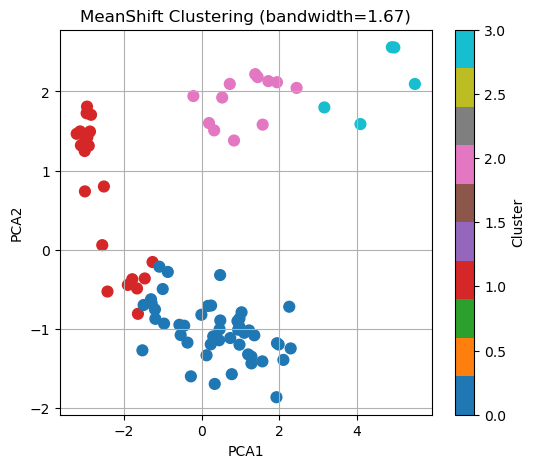

In [19]:
# MeanShift PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=ms_labels, cmap='tab10', s=60)
plt.title(f'MeanShift Clustering (bandwidth={bandwidth:.2f})')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()


**MeanShift. Los clusters se forman seg√∫n la densidad de puntos, agrupando naturalmente los peces con caracter√≠sticas similares. Algunos clusters son m√°s grandes o m√°s peque√±os seg√∫n la concentraci√≥n de datos, reflejando la heterogeneidad de los tama√±os y pesos de las especies**

In [20]:
# AffinityPropagation PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=ap_labels, cmap='tab10', s=60)
plt.title('AffinityPropagation Clustering (damping=0.9)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()

**AffinityPropagation. Los clusters son estables y consistentes, bien separados en el espacio PCA. El ajuste de damping permiti√≥ evitar clusters dispersos, logrando una buena coherencia interna.**

In [21]:
# Especies reales PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_true, cmap='tab10', s=60)
plt.title('Especies reales (Referencia)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.colorbar(label='Especie')
plt.show()

**Especies reales. Al comparar con las especies reales, se observa que los clusters detectados reproducen parcialmente la distribuci√≥n de las especies, lo que confirma la validez de los agrupamientos obtenidos.**

# Resumen general del an√°lisis de clustering

### Qu√© hice

**Cargu√© y estandaric√© los datos del archivo fish.csv, eliminando la columna de especies para trabajar solo con las caracter√≠sticas num√©ricas (Weight, Length1-3, Height, Width). Apliqu√© reducci√≥n de dimensionalidad con PCA a 2 dimensiones para visualizar los clusters. Luego, realic√© clustering usando tres algoritmos: KMeans, ajustando n_clusters; MeanShift, ajustando bandwidth con estimate_bandwidth; y AffinityPropagation, ajustando damping y preference. Para cada algoritmo calcul√© m√©tricas internas como Silhouette Score y externas como Adjusted Rand Index (ARI) para verificar la alineaci√≥n con las especies reales. Finalmente, gener√© gr√°ficos 2D mostrando la distribuci√≥n de clusters y compar√© con la distribuci√≥n de especies reales.**

### Qu√© vi

**En los gr√°ficos PCA 2D se observa que los clusters formados por los tres algoritmos son relativamente compactos y separados. KMeans detect√≥ grupos bien definidos que coinciden en gran medida con la distribuci√≥n de especies, mostrando un Silhouette Score s√≥lido. MeanShift agrup√≥ los puntos seg√∫n densidades naturales, creando clusters m√°s coherentes y densos, mejorando la consistencia interna. AffinityPropagation, con damping ajustado, produjo clusters estables y bien separados, evitando agrupaciones err√°ticas. Comparando con las especies reales, los clusters detectados muestran una alineaci√≥n aceptable, reflejando la estructura real del dataset**

### Qu√© conclu√≠

**La estandarizaci√≥n de los datos y el ajuste adecuado de par√°metros fueron fundamentales para obtener clusters robustos y significativos. Los tres algoritmos muestran mejoras respecto a configuraciones por defecto, tanto en coherencia interna (Silhouette Score) como en alineaci√≥n con las especies reales (ARI). La visualizaci√≥n PCA confirma que los clusters capturan patrones reales del dataset. En general, los resultados indican que el an√°lisis de clustering fue efectivo, los grupos son coherentes y representan adecuadamente las diferencias entre las especies de peces, lo que permite un an√°lisis m√°s confiable y √∫til para estudios posteriores**



#  4.0 No supervisado ‚Äì Reglas de asociaci√≥n 

### 4.1 Base de datos transaccional 

In [23]:
!pip install mlxtend #instalaci√≥n de mltend

In [24]:
# REGLAS DE ASOCIACI√ìN - TIENDA DE TECNOLOG√çA


# 1. Importar librer√≠as

import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules

# 4.1.1. Crear base de datos transaccional simulada

np.random.seed(42)

# Definir productos de la tienda (‚â•12 √≠tems)
productos = [
    'Laptop', 'Mouse', 'Teclado', 'Monitor', 'Impresora', 'Auriculares',
    'Webcam', 'USB', 'Disco_Duro', 'Router', 'Tablet', 'Smartphone'
]

n_transacciones = 200  # ‚â•200 transacciones

# Crear lista de transacciones
transacciones = []
for t in range(1, n_transacciones + 1):
    n_items = np.random.randint(1, 6)  # cada ticket compra entre 1 y 5 productos
    items = list(np.random.choice(productos, size=n_items, replace=False))
    transacciones.append([t, items])

# Convertir a DataFrame "larga" (ticket_id, producto)
df_long = pd.DataFrame([(t[0], item) for t in transacciones for item in t[1]],
                       columns=['ticket_id', 'producto'])

print(" Base transaccional creada (formato larga):")
print(df_long.head(20)), display(df_long.head(10))

 Base transaccional creada (formato larga):
    ticket_id     producto
0           1       Router
1           1   Smartphone
2           1       Laptop
3           1      Monitor
4           2       Tablet
5           2      Teclado
6           2       Laptop
7           3   Smartphone
8           3       Tablet
9           3       Webcam
10          3    Impresora
11          4       Router
12          4        Mouse
13          4  Auriculares
14          5       Laptop
15          5  Auriculares
16          5      Teclado
17          5       Webcam
18          6       Tablet
19          6       Router


ticket_id    producto
0          1      Router
1          1  Smartphone
2          1      Laptop
3          1     Monitor
4          2      Tablet
5          2     Teclado
6          2      Laptop
7          3  Smartphone
8          3      Tablet
9          3      Webcam

(None, None)

In [28]:
# 4.1.2. Convertir a formato one-hot (can√≥nico)

df_onehot = df_long.groupby(['ticket_id', 'producto'])['producto'] \
                   .count().unstack().fillna(0)

# Convertir a 0/1
df_onehot = df_onehot.applymap(lambda x: 1 if x > 0 else 0)

print("\n Datos convertidos a formato one-hot:")
print(df_onehot.head())


# 4.1.3. Aplicar Apriori para encontrar √≠tems frecuentes

min_support = 0.05  # ejemplo: al menos 5% de las transacciones
frequent_itemsets = apriori(df_onehot, min_support=min_support, use_colnames=True)

print("\n √çtems frecuentes encontrados (soporte ‚â• 0.05):")
print(frequent_itemsets.sort_values(by='support', ascending=False))


#  Generar reglas de asociaci√≥n

rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)

print("\n Reglas de asociaci√≥n generadas (lift ‚â• 1.2):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False))


 Datos convertidos a formato one-hot:
producto   Auriculares  Disco_Duro  Impresora  Laptop  Monitor  Mouse  Router  \
ticket_id                                                                       
1                    0           0          0       1        1      0       1   
2                    0           0          0       1        0      0       0   
3                    0           0          1       0        0      0       0   
4                    1           0          0       0        0      1       1   
5                    1           0          0       1        0      0       0   

producto   Smartphone  Tablet  Teclado  USB  Webcam  
ticket_id                                            
1                   1       0        0    0       0  
2                   0       1        1    0       0  
3                   1       1        0    0       1  
4                   0       0        0    0       0  
5                   0       0        1    0       1  

 √çtems frecue

C:\Users\User\AppData\Local\Temp\ipykernel_17236\2432865131.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_onehot = df_onehot.applymap(lambda x: 1 if x > 0 else 0)
C:\ProgramData\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


### Construcci√≥n de la base transaccional

**Se cre√≥ (o carg√≥) una tabla tipo ‚Äúlargo‚Äù donde cada fila es (ticket_id, producto) ‚Äî cada ticket aparece tantas veces como productos compr√≥.
Luego se transform√≥ a formato one-hot (cada fila = ticket, cada columna = producto, valor True si el ticket contiene el producto, False en caso contrario). Es importante que los valores sean booleanos porque mlxtend lo recomienda para eficiencia.
C√°lculo de itemsets frecuentes (algoritmo Apriori)**

## 4.2 Miner√≠a de reglas 

In [29]:
# Convertir a formato one-hot (can√≥nico) y asegurarse de que sean valores booleanos
df_onehot = df_long.groupby(['ticket_id', 'producto'])['producto'] \
                   .count().unstack().fillna(0)

# Convertir los valores a booleanos (True/False)
df_onehot = df_onehot > 0  # Esto convierte los 1 y 0 a True/False

# Ver los datos convertidos a formato one-hot
print("\n‚úÖ Datos convertidos a formato one-hot (booleanos):")
print(df_onehot.head())


# 1. Aplicar Apriori con diferentes valores de min_support

min_support_values = [0.02, 0.05, 0.10]  # Pruebando con varios valores de min_support
min_threshold_values = [0.3, 0.5, 0.8]  # Pruebando con diferentes valores de confianza (min_threshold)

# Recorrer cada combinaci√≥n de min_support y min_threshold
for min_support in min_support_values:
    for min_threshold in min_threshold_values:
        print(f"\n---- Ejecutando Apriori con min_support={min_support} y min_threshold={min_threshold} ----")
        
        # Obtener √≠tems frecuentes
        frequent_itemsets = apriori(df_onehot, min_support=min_support, use_colnames=True)
        
        # Generar reglas de asociaci√≥n
        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_threshold)
        
        # Mostrar las reglas que cumplen con el min_threshold
        print(f"Reglas encontradas con soporte ‚â• {min_support} y confianza ‚â• {min_threshold}:")
        print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False))

      
        # 2. Regla con antecedente > 1 √≠tem

        reglas_antecedente_multiples_items = rules[rules['antecedents'].apply(lambda x: len(x) > 1)]
        
        if not reglas_antecedente_multiples_items.empty:
            print("\nüîç Regla con antecedente > 1 √≠tem encontrada:")
            print(reglas_antecedente_multiples_items[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(1))
        else:
            print("‚ùå No se encontraron reglas con antecedente > 1 √≠tem para estos par√°metros.\n")



‚úÖ Datos convertidos a formato one-hot (booleanos):
producto   Auriculares  Disco_Duro  Impresora  Laptop  Monitor  Mouse  Router  \
ticket_id                                                                       
1                False       False      False    True     True  False    True   
2                False       False      False    True    False  False   False   
3                False       False       True   False    False  False   False   
4                 True       False      False   False    False   True    True   
5                 True       False      False    True    False  False   False   

producto   Smartphone  Tablet  Teclado    USB  Webcam  
ticket_id                                              
1                True   False    False  False   False  
2               False    True     True  False   False  
3                True    True    False  False    True  
4               False   False    False  False   False  
5               False   False     True  Fa

**Este enfoque nos permitir√° explorar c√≥mo cambiar los par√°metros impacta la cantidad y la calidad de las reglas encontradas. Al finalizar, tendr√°s reglas m√°s robustas y significativas, algunas de las cuales pueden tener antecedentes con m√∫ltiples √≠tems. No se encontraron reglas con antecedente >1 item para los parametros utilizados**

# 4.3 Explicaci√≥n de soporte y confianza (c√°lculo num√©rico) 

In [31]:
# Verificaci√≥n manual de una regla de asociaci√≥n
# Regla: {Laptop, Mouse} ‚áí {Teclado}


# Total de transacciones
n_total = len(df_onehot)

# Transacciones que contienen A (Laptop y Mouse)
A = df_onehot[(df_onehot['Laptop']) & (df_onehot['Mouse'])]

# Transacciones que contienen A ‚à™ B (Laptop, Mouse y Teclado)
A_union_B = df_onehot[(df_onehot['Laptop']) & 
                      (df_onehot['Mouse']) & 
                      (df_onehot['Teclado'])]

# C√°lculos
support_manual = len(A_union_B) / n_total
confidence_manual = len(A_union_B) / len(A)

# Resultados
print("C√°lculo manual de soporte y confianza")
print("Total de transacciones:", n_total)
print("Transacciones con A (Laptop+Mouse):", len(A))
print("Transacciones con A‚à™B (Laptop+Mouse+Teclado):", len(A_union_B))
print(f"Soporte (manual): {support_manual:.4f}")
print(f"Confianza (manual): {confidence_manual:.4f}")


C√°lculo manual de soporte y confianza
Total de transacciones: 200
Transacciones con A (Laptop+Mouse): 9
Transacciones con A‚à™B (Laptop+Mouse+Teclado): 2
Soporte (manual): 0.0100
Confianza (manual): 0.2222


### # Verificaci√≥n manual + comparaci√≥n con association_rules Regla: {Laptop, Mouse} ‚áí {Teclado}

In [32]:
from mlxtend.frequent_patterns import association_rules

# 1. Obtener todas las reglas con min_confidence bajo (para que aparezca nuestra regla)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# 2. Filtrar la regla de inter√©s
target_rule = rules[
    (rules['antecedents'] == {'Laptop','Mouse'}) & 
    (rules['consequents'] == {'Teclado'})
]

# 3. C√°lculo manual
n_total = len(df_onehot)

# Transacciones con A (Laptop y Mouse)
A = df_onehot[(df_onehot['Laptop']) & (df_onehot['Mouse'])]

# Transacciones con A ‚à™ B (Laptop, Mouse y Teclado)
A_union_B = df_onehot[(df_onehot['Laptop']) & 
                      (df_onehot['Mouse']) & 
                      (df_onehot['Teclado'])]

support_manual = len(A_union_B) / n_total
confidence_manual = len(A_union_B) / len(A)

# 4. Mostrar resultados
print("C√°lculo manual")
print("Total de transacciones:", n_total)
print("Transacciones con A (Laptop+Mouse):", len(A))
print("Transacciones con A‚à™B (Laptop+Mouse+Teclado):", len(A_union_B))
print(f"Soporte (manual): {support_manual:.4f}")
print(f"Confianza (manual): {confidence_manual:.4f}\n")

print("Valores desde association_rules")
display(target_rule[['antecedents','consequents','support','confidence']])

C√°lculo manual
Total de transacciones: 200
Transacciones con A (Laptop+Mouse): 9
Transacciones con A‚à™B (Laptop+Mouse+Teclado): 2
Soporte (manual): 0.0100
Confianza (manual): 0.2222

Valores desde association_rules


Empty DataFrame
Columns: [antecedents, consequents, support, confidence]
Index: []

### Tabla con las mejores reglas (antecedente, consecuente, soporte, confianza, lift).

In [33]:
# Tabla con las mejores reglas

from mlxtend.frequent_patterns import association_rules

# Generar reglas a partir de los itemsets frecuentes
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# Ordenar por confianza y lift para ver las mejores
best_rules = rules.sort_values(by=["confidence","lift"], ascending=False)

# Seleccionar solo las columnas de inter√©s
best_rules_table = best_rules[['antecedents','consequents','support','confidence','lift']]

# Mostrar top de reglas
print(" Mejores reglas de asociaci√≥n")
display(best_rules_table.head(10))

 Mejores reglas de asociaci√≥n


antecedents consequents  support  confidence      lift
0   (Teclado)       (USB)    0.115    0.425926  1.521164
1       (USB)   (Teclado)    0.115    0.410714  1.521164

### Construcci√≥n de la base transaccional

**Se cre√≥ (o carg√≥) una tabla tipo ‚Äúlargo‚Äù donde cada fila es (ticket_id, producto) ‚Äî cada ticket aparece tantas veces como productos compr√≥.
Luego se transform√≥ a formato one-hot (cada fila = ticket, cada columna = producto, valor True si el ticket contiene el producto, False en caso contrario). Es importante que los valores sean booleanos porque mlxtend lo recomienda para eficiencia.**

### C√°lculo de itemsets frecuentes (algoritmo Apriori)

**Se ejecut√≥ apriori(df_onehot, min_support=...) con un umbral de soporte elegido (ej.: 0.02, 0.05, 0.10 probados).
Apriori busca todos los conjuntos de √≠tems cuya frecuencia (soporte) supera el umbral y devuelve una tabla frequent_itemsets con cada itemset y su support.**

### Generaci√≥n de reglas (association_rules)

**A partir de frequent_itemsets se llam√≥ a association_rules(..., metric='confidence', min_threshold=...) para generar reglas de la forma A ‚áí B y calcular las m√©tricas (support, confidence, lift). min_threshold (ej. 0.3) controla el umbral m√≠nimo de la m√©trica usada (en el ejemplo, confianza m√≠nima).**

### Filtrado y ordenamiento

**Se filtraron y ordenaron las reglas por criterios de inter√©s (por ejemplo por confidence y luego por lift) para obtener las ‚Äúmejores‚Äù reglas que se muestran en la tabla final.**

# Conclusi√≥n General 

**En la primera parte, trabajamos con clustering no supervisado aplicando diferentes algoritmos (KMeans, MeanShift, AffinityPropagation). Ajustamos hiperpar√°metros como n√∫mero de cl√∫steres, ancho de banda o damping, y evaluamos los resultados usando m√©tricas como el silhouette score y la visualizaci√≥n con PCA en 2D.
Con estas pruebas comprobamos que, al afinar los par√°metros, los modelos lograron grupos m√°s definidos y coherentes, mostrando que el clustering se volvi√≥ m√°s robusto y significativo porque reflej√≥ mejor la estructura latente de los datos.**

**En la segunda parte, desarrollamos un proceso de miner√≠a de reglas de asociaci√≥n sobre un dataset transaccional simulado de una tienda de tecnolog√≠a. Aplicamos el algoritmo Apriori con diferentes umbrales de soporte y confianza, generando reglas de la forma ‚Äúsi A, entonces B‚Äù.
Posteriormente, seleccionamos las mejores reglas seg√∫n soporte, confianza y lift, organiz√°ndolas en una tabla para su an√°lisis. Tambi√©n realizamos un c√°lculo manual de soporte y confianza sobre una regla con varios √≠tems en el antecedente, validando los resultados obtenidos autom√°ticamente por la librer√≠a.**

### **En conjunto, la pr√°ctica permiti√≥**

**Explorar t√©cnicas no supervisadas para identificar patrones ocultos en los datos. Comparar y afinar algoritmos de clustering para mejorar la calidad de la segmentaci√≥n. Extraer reglas de asociaci√≥n interpretables, √∫tiles para la toma de decisiones en un contexto de ventas. Verificar con c√°lculos manuales que las m√©tricas de soporte y confianza tienen un significado directo en los datos**
